# Projet Machine Learning

## Imports

In [147]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import requests
import shutil
import numpy
import math
import random
import os
import json
from PIL import Image
from collections import defaultdict
from ipywidgets import GridspecLayout, Image, interact, widgets
from scipy.spatial import KDTree
from matplotlib import pyplot as plt, image as mpimg
from sklearn.cluster import KMeans
import webcolors
from webcolors import CSS3_NAMES_TO_HEX, rgb_to_name
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

## 1 : Téléchargement des Images Wikidata

In [1]:
endpoint_url = "https://query.wikidata.org/sparql"

# Get cars
query = """SELECT DISTINCT ?item ?itemLabel (SAMPLE(?image) AS ?sampleImage)  
WHERE
{
  ?item wdt:P279 wd:Q1420;
        wdt:P18 ?image.

  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr". }
}
GROUP BY ?item ?itemLabel
LIMIT 150
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

print(results)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["item"]["value"],
            result["itemLabel"]["value"],
            result["sampleImage"]["value"],
        )
    )

ModuleNotFoundError: No module named 'SPARQLWrapper'

In [37]:
dataframe = pd.DataFrame(array, columns=["id", "nom", "image"])
dataframe = dataframe.astype(
    dtype={"id": "<U200", "nom": "<U200", "image": "<U200"}
)
dataframe

C:\Users\grego\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\grego\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


,id,nom,image
0,http://www.wikidata.org/entity/Q4050653,Q4050653,http://commons.wikimedia.org/wiki/Special:File...
1,http://www.wikidata.org/entity/Q111208461,DS E-Tense Performance Concept,http://commons.wikimedia.org/wiki/Special:File...
2,http://www.wikidata.org/entity/Q17073503,Q17073503,http://commons.wikimedia.org/wiki/Special:File...
3,http://www.wikidata.org/entity/Q117232744,Kia Concept EV5,http://commons.wikimedia.org/wiki/Special:File...
4,http://www.wikidata.org/entity/Q113039073,Q113039073,http://commons.wikimedia.org/wiki/Special:File...
...,...,...,...
145,http://www.wikidata.org/entity/Q7976422,Wayne Lifeguard,http://commons.wikimedia.org/wiki/Special:File...
146,http://www.wikidata.org/entity/Q104599203,Q104599203,http://commons.wikimedia.org/wiki/Special:File...
147,http://www.wikidata.org/entity/Q42847657,Q42847657,http://commons.wikimedia.org/wiki/Special:File...
148,http://www.wikidata.org/entity/Q1436782,Ford Contour,http://commons.wikimedia.org/wiki/Special:File...


In [38]:
def download_image(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        if not os.path.exists('Images'):
            os.makedirs('Images')
        filename = os.path.join('Images', os.path.basename(url))
        with open(filename, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
        return filename
    else:
        return None

In [39]:
dataframe.image.apply(download_image)

0          Images\MPM%20PS%20160%20%2839851917005%29.jpg
1      Images\DS%20E-Tense%20-%20FAI%202017%20%281-3%...
2      Images\Berliet%20%27Dauphine%27%20berline%20ca...
3                 Images\Kia%20EV5%20Concept%20IMG01.jpg
4      Images\1909%20Lane%20Steam%20Cars%20Brochure%2...
                             ...                        
145    Images\Virginia%20Overland%20Bus%20365%201988%...
146    Images\Iveco%20Manticore%20MTV%20prototype%201...
147    Images\WMC%20P%20AS17%20Bentley%20EXP%2012%20S...
148           Images\1998-2000%20Ford%20Contour%20SE.jpg
149    Images\Toyota%20E-AE86%20Sprinter%20Trueno%20G...
Name: image, Length: 150, dtype: object

### On renomme les images

In [40]:
# Chemin du dossier contenant les images
dossier_images = "Images"

# Liste des extensions d'images supportées
extensions_images = [".jpg", ".jpeg", ".png", ".gif", ".bmp"]

# Fonction pour renommer les images
def renommer_images(dossier, prefixe="Image_"):
    # Récupérer la liste des fichiers dans le dossier et les trier
    fichiers = sorted([fichier for fichier in os.listdir(dossier) if any(fichier.lower().endswith(ext) for ext in extensions_images)])
    
    # Compteur pour générer les nouveaux noms
    compteur = 1
    # Parcourir tous les fichiers
    for fichier in fichiers:
        # Construire le nouveau nom du fichier
        nouveau_nom = f"{prefixe}{compteur}{os.path.splitext(fichier)[1]}"
        # Renommer le fichier
        os.rename(os.path.join(dossier, fichier), os.path.join(dossier, nouveau_nom))
        # Incrémenter le compteur
        compteur += 1
        
    print("Images renommées")

# Appeler la fonction pour renommer les images dans le dossier spécifié
renommer_images(dossier_images)


Images renommées


## 2 : Extraire les métadonnées

In [51]:
def get_image_info(image_path):
    # Ouvrir l'image avec PIL
    print(image_path)
    with Image.open(image_path) as img:
        # Récupérer les informations demandées
        image_info = {
            "taille": img.size,
            "format": img.format,
            "orientation": "paysage" if img.width > img.height else "portrait" if img.height > img.width else "carre",
            "tags": []
        }
        
        # Vérifier si les informations EXIF existent
        exif_info = img._getexif()
        if exif_info:
            # Ajouter la date de création et le modèle d'appareil photo si disponibles
            image_info["date_creation"] = exif_info.get(36867)  # 36867 est le code EXIF pour la date de création
            image_info["modele_appareil"] = exif_info.get(272)   # 272 est le code EXIF pour le modèle d'appareil photo
    
    return image_info

def get_images_info(directory):
    # Liste des fichiers dans le répertoire
    image_files = os.listdir(directory)

    # Dictionnaire pour stocker les informations de chaque image
    images_info = {}

    # Parcourir chaque fichier image et récupérer les informations
    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        # Vérifier si le fichier est une image
        if os.path.isfile(image_path) and image_path.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.gif')):
            # Extraire le nom de fichier sans extension
            image_name = os.path.splitext(image_file)[0]
            images_info[image_name] = get_image_info(image_path)
    
    return images_info


# Répertoire contenant les images
directory = "./Images/"

# Récupérer les informations des images
images_info = get_images_info(directory)

# Enregistrer les informations dans un fichier JSON
output_json_file = 'images_data2.json'
with open(output_json_file, 'w') as json_file:
    json.dump(images_info, json_file, indent=4)

print("Les informations des images ont été enregistrées dans le fichier:", output_json_file)


./Images/Image_1.JPG
./Images/Image_10.jpg
./Images/Image_100.jpg
./Images/Image_101.jpg
./Images/Image_102.jpg
./Images/Image_103.jpg
./Images/Image_104.jpg
./Images/Image_105.jpg
./Images/Image_106.jpg
./Images/Image_107.jpg
./Images/Image_108.jpg
./Images/Image_109.jpg
./Images/Image_11.jpg
./Images/Image_110.jpg
./Images/Image_111.JPG
./Images/Image_112.JPG
./Images/Image_113.jpg
./Images/Image_114.jpg
./Images/Image_115.jpg
./Images/Image_116.jpg
./Images/Image_117.JPG
./Images/Image_118.JPG
./Images/Image_119.jpg
./Images/Image_12.jpg
./Images/Image_120.jpg
./Images/Image_121.jpg
./Images/Image_122.jpg
./Images/Image_123.jpg
./Images/Image_124.JPG
./Images/Image_125.jpg
./Images/Image_126.jpg
./Images/Image_127.jpg
./Images/Image_128.jpg
./Images/Image_129.JPG
./Images/Image_13.jpg
./Images/Image_130.jpg
./Images/Image_131.jpeg
./Images/Image_132.jpg
./Images/Image_133.jpg
./Images/Image_134.jpg
./Images/Image_135.jpg
./Images/Image_136.jpg
./Images/Image_137.jpg
./Images/Image_1

## 2 : Étiquetage et annotation

### Sélection des Images via index pour ne pas surcharger l'affichage

In [55]:
images = []
directory = "./Images"
start_index = 0
end_index = 150

# Fonction pour trier les images par leur numéro
def tri_numerique(nom_image):
    parts = nom_image.split("_")
    if len(parts) >= 2:
        try:
            return int(parts[1].split(".")[0])
        except ValueError:
            return float('inf')  # Si la conversion échoue, renvoie une valeur infinie
    else:
        return float('inf')  # Si le format de nommage n'est pas valide, renvoie une valeur infinie

# Parcourir les fichiers dans le répertoire d'images
for i, file in enumerate(sorted(os.listdir(directory), key=tri_numerique)):
    # Vérifier si l'index de l'image est dans la plage souhaitée
    if start_index <= tri_numerique(file) <= end_index:
        image_path = os.path.join(directory, file)
        # Vérifier si le fichier est une image
        if os.path.isfile(image_path):
            _, extension = os.path.splitext(image_path)
            # Vérifier si le fichier a une extension d'image valide
            if extension.lower() in ['.jpg', '.jpeg', '.png', '.gif']:
                images.append(image_path)

print(images)


['./Images\\Image_1.jpg', './Images\\Image_2.jpg', './Images\\Image_3.jpg', './Images\\Image_4.jpg', './Images\\Image_5.jpg', './Images\\Image_6.jpg', './Images\\Image_7.jpg', './Images\\Image_8.jpg', './Images\\Image_9.jpg', './Images\\Image_10.jpg', './Images\\Image_11.jpg', './Images\\Image_12.jpg', './Images\\Image_13.jpg', './Images\\Image_14.jpg', './Images\\Image_15.jpg', './Images\\Image_16.jpg', './Images\\Image_17.jpg', './Images\\Image_18.jpg', './Images\\Image_19.jpg', './Images\\Image_20.jpg', './Images\\Image_21.jpg', './Images\\Image_22.jpg', './Images\\Image_23.jpg', './Images\\Image_24.jpg', './Images\\Image_25.jpg', './Images\\Image_26.jpg', './Images\\Image_27.jpg', './Images\\Image_28.jpg', './Images\\Image_29.jpg', './Images\\Image_30.jpg', './Images\\Image_31.jpg', './Images\\Image_32.jpg', './Images\\Image_33.jpg', './Images\\Image_34.jpg', './Images\\Image_35.jpg', './Images\\Image_36.jpg', './Images\\Image_37.jpg', './Images\\Image_38.jpg', './Images\\Image_39.

### Ajout des tags aux images

In [26]:
paths = []

checkboxes = [widgets.Checkbox(value=False, description='Favorite') for _ in range(len(images))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=len(images), width='400px')
for i, (img, checkbox) in enumerate(zip(images, checkboxes)):
  file = open(img, "rb")
  image = file.read()
  image_widget = widgets.Image(
    value=image,
    width=100,
    height=100,
  )
  layout[i,0] = image_widget
  layout[i, 1] = checkbox

# Button to get selected images
button = widgets.Button(description="Select")

# Output widget to display selected images
output = widgets.Output()

# Function to get selected images
def get_selected_images(btn):
    selected_images = [os.path.splitext(os.path.basename(images[i]))[0] for i, checkbox in enumerate(checkboxes) if checkbox.value]
    print(selected_images)
    with open("images_data.json", "r+") as f:
        data = json.load(f)
        for image_name in selected_images:
            if "tags" in data[image_name]:
                # Vérifier si le champ "tags" existe déjà
                if "truck" not in data[image_name]["tags"]:
                    # Ajouter "sport" uniquement si ce n'est pas déjà présent
                    data[image_name]["tags"].append("truck")
            else:
                # Si le champ "tags" n'existe pas, le créer avec "sport"
                data[image_name]["tags"] = ["truck"]
        f.seek(0)
        json.dump(data, f, indent=4)
        f.truncate()
        

# Link button click event to function
button.on_click(get_selected_images)

# Display the layout and button
display(layout, button, output)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01\x00\xb4\x00\xb4\x00\x00\xf…

Button(description='Select', style=ButtonStyle())

Output()

['Image_45']


### Extraction des couleurs de chaque image

### Insertion du champ colors dans le JSON

In [77]:
# Ajout du champ color à chaque Image
with open("images_data.json", "r+") as f:
        data = json.load(f)
        for imageClr in data:
            if "colors" in data[imageClr]:
                print("Déjà Présent")
            else:
                # Si le champ "colors" n'existe pas, le créer avec "sport"
                data[imageClr]["colors"] = []
        f.seek(0)
        json.dump(data, f, indent=4)
        f.truncate()


### Fonction pour obtenir les couleurs au format rgb

In [48]:
def getColorsFromImage(self):
        colors = []
        imgfile = Image.open(self)
        imgfile = imgfile.resize((300, 300))  # optional, to reduce time
        nb_clusters = 5
        numarray = numpy.array(imgfile.getdata(), numpy.uint8)
        if type(numarray[0]) == numpy.uint8:
            # for each pixel, convert to a 3-tuple of ints
            numarray = numpy.array([[numarray[i], numarray[i], numarray[i]] for i in range(0, len(numarray))])

        clusters = KMeans(n_clusters=nb_clusters, n_init=2)
        # if image is black and white
        # if len(numarray[0]) == 2:
        clusters.fit(numarray)
        npbins = numpy.arange(0, nb_clusters + 1)
        histogram = numpy.histogram(clusters.labels_, bins=npbins)
        labels = numpy.unique(clusters.labels_)
        for i in range(nb_clusters):
            colorRGB = (
                math.ceil(clusters.cluster_centers_[i][0]),
                math.ceil(clusters.cluster_centers_[i][1]),
                math.ceil(clusters.cluster_centers_[i][2]),
            )
            colors.append(colorRGB)
        return colors
        

### Fonction pour obtenir le nom d'une couleur à partir de sa valeur rgb

In [59]:
def convert_rgb_to_names(rgb_tuple):
        # a dictionary of all the hex and their respective names in css3
        css3_db = CSS3_NAMES_TO_HEX
        names = []
        rgb_values = []
        for color_name, color_hex in css3_db.items():
            names.append(color_name)
            rgb_values.append(hex_to_rgb(color_hex))

        kdt_db = KDTree(rgb_values)
        distance, index = kdt_db.query(rgb_tuple)
        return names[index]


### On ajoute les noms des couleurs dans le JSON

In [84]:
with open("images_data.json", "r+") as f:
    data = json.load(f)
    for img in images:
        names = []
        image_name = os.path.splitext(os.path.basename(img))[0]
        rgb_colors = getColorsFromImage(img)
        for color in rgb_colors:
            color_name = convert_rgb_to_names(color)
            names.append(color_name)
        print(names)
        if "colors" in data[image_name]:
            # Ajouter des couleurs
            data[image_name]["colors"].append(names)
        else:
            print("Error : pas de champ colors")
    f.seek(0)
    json.dump(data, f, indent=4)
    f.truncate()

[(164, 157, 154), (102, 96, 126), (54, 53, 61), (231, 217, 170), (40, 24, 159)]
['darkgrey', 'dimgray', 'darkslategray', 'palegoldenrod', 'midnightblue']
[(152, 152, 152), (25, 25, 25), (117, 117, 117), (189, 189, 189), (73, 73, 73)]
['darkgrey', 'black', 'gray', 'silver', 'darkslategray']
[(62, 53, 57), (233, 224, 218), (20, 17, 23), (114, 108, 109), (176, 164, 159)]
['darkslategray', 'gainsboro', 'black', 'dimgray', 'darkgrey']
[(104, 105, 74), (169, 180, 114), (232, 209, 205), (239, 87, 88), (55, 38, 26)]
['dimgray', 'darkkhaki', 'lightgray', 'tomato', 'darkslategray']
[(90, 82, 84), (126, 128, 131), (191, 91, 104), (57, 48, 50), (200, 190, 197)]
['dimgray', 'gray', 'indianred', 'darkslategray', 'silver']
[(85, 84, 85), (219, 224, 226), (30, 29, 30), (171, 175, 177), (122, 123, 124)]
['dimgray', 'gainsboro', 'black', 'darkgrey', 'gray']
[(150, 48, 33), (181, 178, 170), (67, 56, 49), (141, 114, 106), (252, 251, 250)]
['brown', 'darkgrey', 'darkslategray', 'gray', 'snow']
[(213, 217, 

## 3 : Analyse de données

### Création de plusieurs utilisateurs via sélection d'images

In [192]:
num_images_to_display = 40

checkboxes = [widgets.Checkbox(value=False, description='Favorite') for _ in range(len(images))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=num_images_to_display, width='400px')
for i, (img, checkbox) in enumerate(zip(images[:num_images_to_display], checkboxes[:num_images_to_display])):
    file = open(img, "rb")
    image = file.read()
    image_widget = widgets.Image(
        value=image,
        width=100,
        height=100,
    )
    layout[i, 0] = image_widget
    layout[i, 1] = checkbox

# Button to get selected images
button = widgets.Button(description="Select")

# Output widget to display selected images
output = widgets.Output()

# Function to get selected images
def get_selected_images(btn):
    selected_images = [os.path.splitext(os.path.basename(images[i]))[0] for i, checkbox in enumerate(checkboxes) if checkbox.value]
    unselected_images = [os.path.splitext(os.path.basename(images[i]))[0] for i, checkbox in enumerate(checkboxes[:num_images_to_display]) if not checkbox.value]
    print(unselected_images)
        
    # Crée un objet utilisateur contenant l'id, le nom d'utilisateur et les images sélectionnées
    user_data = {
        "id": 4,  
        "username": "random_user",
        "selected_images": selected_images,
        "unselected_images": unselected_images
    }
    
    # Vérifie si le fichier JSON existe déjà
    if os.path.exists("user_data.json"):
        # Si le fichier existe, charge les données existantes
        with open("user_data.json", "r") as f:
            existing_data = json.load(f)
    else:
        # Si le fichier n'existe pas, initialise la liste des utilisateurs
        existing_data = []
    
    # Ajoute les données de l'utilisateur actuel à la liste existante
    existing_data.append("old_user")
    
    # Écrit la liste d'objets utilisateur dans le fichier JSON
    with open("user_data.json", "w") as f:
        json.dump(existing_data, f, indent=4)
        

# Lie l'événement de clic du bouton à la fonction
button.on_click(get_selected_images)

# Affiche la mise en page et le bouton
display(layout, button, output)


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01\x00H\x00H\x00\x00\xff\xe1/…

Button(description='Select', style=ButtonStyle())

Output()

### Statistiques sur les utilisateurs 

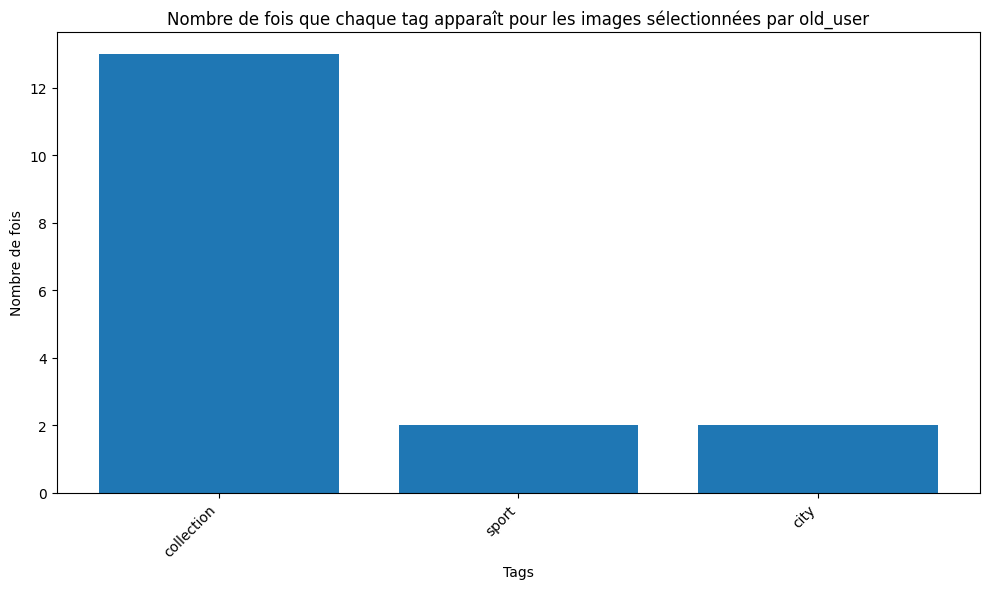

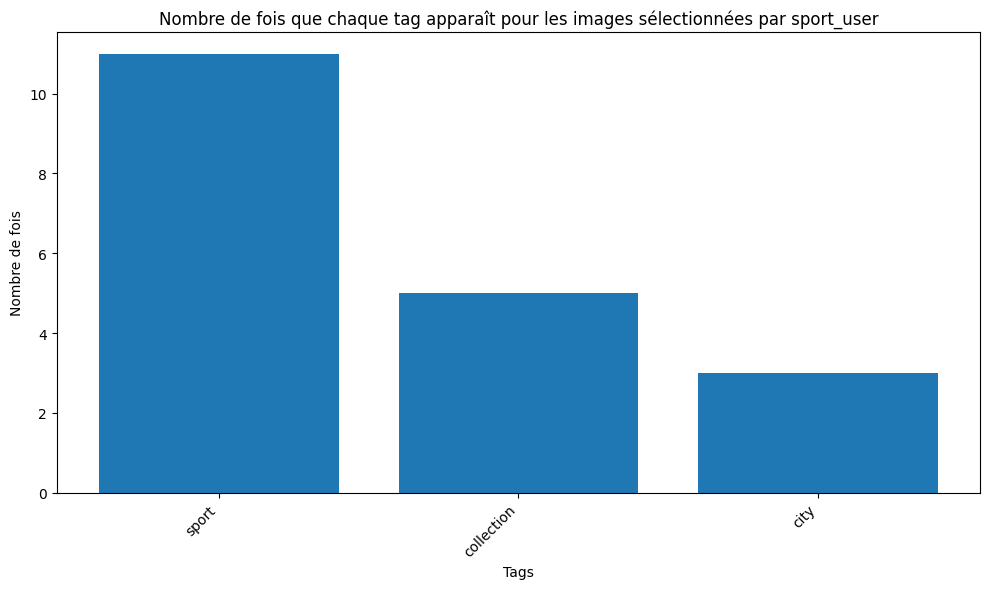

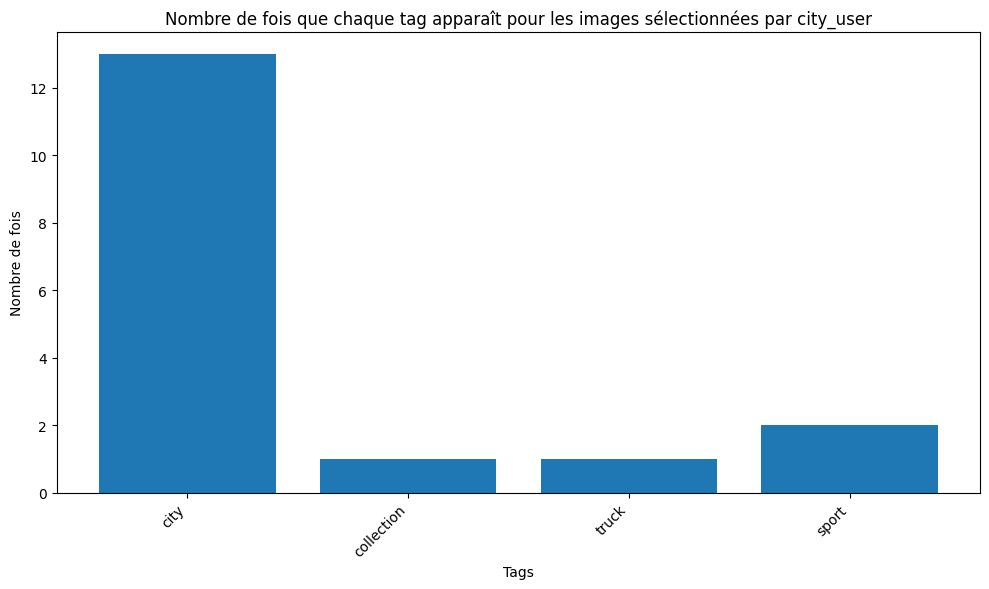

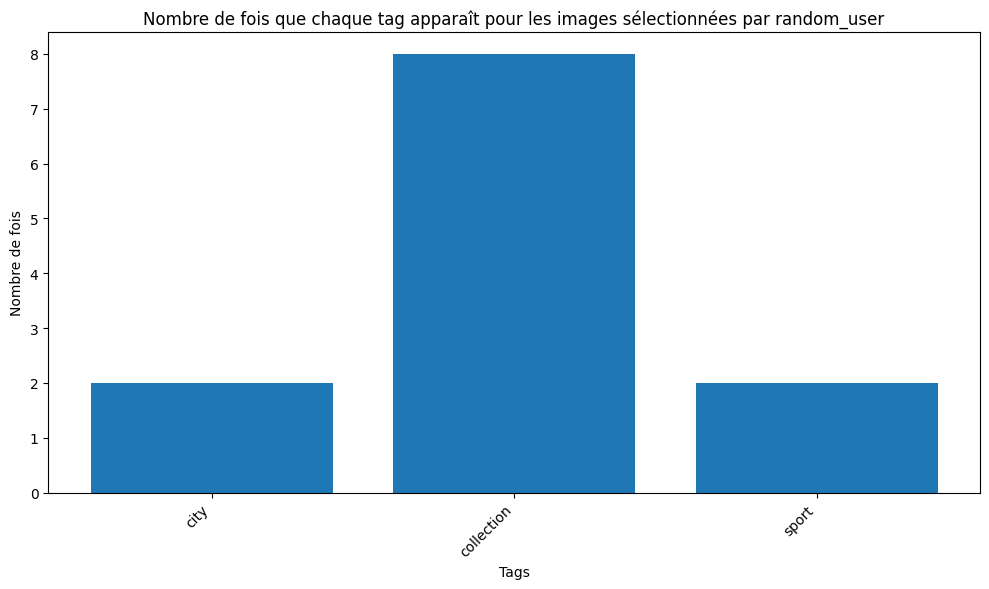

In [99]:
# Charger les données JSON des deux fichiers
with open('user_data.json', 'r') as file:
    user_data = json.load(file)

with open('images_data_view.json', 'r') as file:
    image_data = json.load(file)

# Initialiser un dictionnaire pour stocker le nombre de tags pour chaque utilisateur
user_tag_counts = {}

# Parcourir les objets dans le fichier JSON des utilisateurs
for user in user_data:
    username = user['username']
    tag_counts = {}  # Initialiser un dictionnaire pour stocker le nombre de tags pour cet utilisateur
    for image_name in user['selected_images']:
        # Récupérer les informations de l'image à partir du fichier JSON des images
        image_info = next((image for image in image_data if image['nom'] == image_name), None)
        if image_info:
            # Parcourir les tags de l'image et mettre à jour le dictionnaire des comptes de tags
            for tag in image_info.get('tags', []):
                tag_counts[tag] = tag_counts.get(tag, 0) + 1
    # Mettre à jour le dictionnaire principal avec les comptes de tags pour cet utilisateur
    user_tag_counts[username] = tag_counts

# Créer un graphique pour chaque utilisateur
for username, tag_counts in user_tag_counts.items():
    tags = list(tag_counts.keys())
    counts = list(tag_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts)
    plt.xlabel('Tags')
    plt.ylabel('Nombre de fois')
    plt.title(f'Nombre de fois que chaque tag apparaît pour les images sélectionnées par {username}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


### Fichier Json des préférences de chaque utilisateur 

In [34]:
# Charger les données JSON des deux fichiers
with open('user_data.json', 'r') as file:
    user_data = json.load(file)

with open('images_data_view.json', 'r') as file:
    image_data = json.load(file)

# Initialiser un dictionnaire pour stocker les préférences de chaque utilisateur
user_preferences = {}

# Parcourir les objets dans le fichier JSON des utilisateurs
for user in user_data:
    username = user['username']
    preferred_format = None
    preferred_tag = None
    preferred_width_category = None
    preferred_height_category = None
    preferred_color = None

    # Initialiser des dictionnaires pour stocker les comptes de tags, de couleurs et de catégories de taille
    tag_counts = {}
    color_counts = {}
    width_categories = {"width < 1000": 0, "1000 <= width < 2000": 0, "2000 <= width < 3000": 0, "3000 <= width < 4000": 0, "width >= 4000": 0}
    height_categories = {"height < 1000": 0, "1000 <= height < 2000": 0, "2000 <= height < 3000": 0, "3000 <= height < 4000": 0, "height >= 4000": 0}

    for image_name in user['selected_images']:
        # Récupérer les informations de l'image à partir du fichier JSON des images
        image_info = next((image for image in image_data if image['nom'] == image_name), None)
        if image_info:
            # Mettre à jour les comptes de tags
            for tag in image_info.get('tags', []):
                tag_counts[tag] = tag_counts.get(tag, 0) + 1

            # Mettre à jour les comptes de couleurs
            for color_list in image_info.get('colors', []):
                for color in color_list:
                    color_counts[color] = color_counts.get(color, 0) + 1

            # Mettre à jour les catégories de taille
            width, height = image_info.get('taille', [0, 0])
            if width < 1000:
                width_categories["width < 1000"] += 1
            elif 1000 <= width < 2000:
                width_categories["1000 <= width < 2000"] += 1
            elif 2000 <= width < 3000:
                width_categories["2000 <= width < 3000"] += 1
            elif 3000 <= width < 4000:
                width_categories["3000 <= width < 4000"] += 1
            else:
                width_categories["width >= 4000"] += 1

            if height < 1000:
                height_categories["height < 1000"] += 1
            elif 1000 <= height < 2000:
                height_categories["1000 <= height < 2000"] += 1
            elif 2000 <= height < 3000:
                height_categories["2000 <= height < 3000"] += 1
            elif 3000 <= height < 4000:
                height_categories["3000 <= height < 4000"] += 1
            else:
                height_categories["height >= 4000"] += 1

            # Mettre à jour le format d'image préféré
            if preferred_format is None:
                preferred_format = image_info.get('format')

    # Déterminer le tag préféré
    if tag_counts:
        preferred_tag = max(tag_counts, key=tag_counts.get)

    # Déterminer la couleur préférée
    if color_counts:
        preferred_color = max(color_counts, key=color_counts.get)

    # Déterminer la catégorie de largeur préférée
    if width_categories:
        preferred_width_category = max(width_categories, key=width_categories.get)

    # Déterminer la catégorie de hauteur préférée
    if height_categories:
        preferred_height_category = max(height_categories, key=height_categories.get)

    # Stocker les préférences de l'utilisateur dans le dictionnaire
    user_preferences[username] = {
        'preferred_format': preferred_format,
        'preferred_tag': preferred_tag,
        'preferred_width_category': preferred_width_category,
        'preferred_height_category': preferred_height_category,
        'preferred_color': preferred_color
    }

# Écrire les préférences des utilisateurs dans un nouveau fichier JSON
with open('user_preferences.json', 'w') as file:
    json.dump(user_preferences, file, indent=4)


## 4 : Visualisation des données

#### Notre fichier JSON n'est pas au bon format pour la visualisation des données, on le modifie pour pouvoir accéder à chaque objet 

In [32]:
# Charger les données JSON depuis le fichier d'origine
with open('images_data.json', 'r') as file:
    original_data = json.load(file)

# Créer une liste pour stocker les nouveaux objets
nouveau_json = []

# Parcourir chaque objet d'image dans le JSON d'origine
for nom_image, details_image in original_data.items():
    # Extraire le numéro de l'image à partir du nom
    numero_image = int(nom_image.split("_")[1])
    
    # Créer un dictionnaire pour le nouvel objet
    nouvel_objet = {
        "id": numero_image,
        "nom": nom_image,
        "taille": details_image["taille"],
        "format": details_image["format"],
        "orientation": details_image["orientation"],
        "tags": details_image["tags"],
        "date_creation": details_image.get("date_creation"),  
        "modele_appareil": details_image.get("modele_appareil"), 
        "colors": details_image["colors"]
    }
    
    # Ajouter le nouvel objet à la liste
    nouveau_json.append(nouvel_objet)

# Écrire le nouveau JSON dans un fichier
with open("images_data_view.json", "w") as file:
    json.dump(nouveau_json, file, indent=4)


### Nombre d'images pour chaque tag

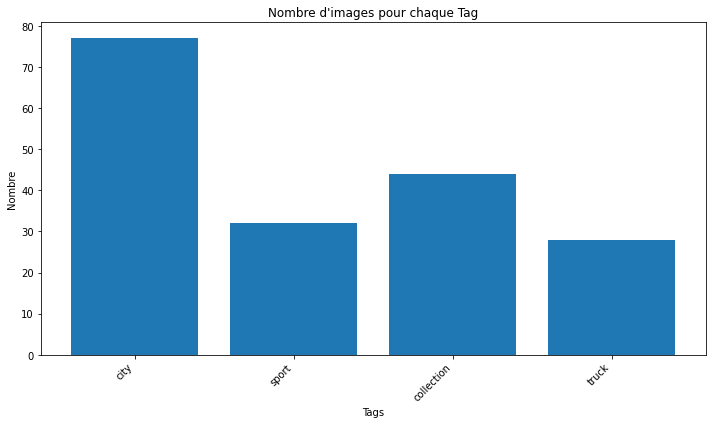

In [35]:
# Charger les données JSON depuis un fichier
with open('./images_data_view.json', 'r') as file:
    data = json.load(file)
    
    # Analyser les données pour compter le nombre de chaque tag
    tag_counts = {}
    for obj in data:
        tags = obj.get('tags', [])
        for tag in tags:
            tag_counts[tag] = tag_counts.get(tag, 0) + 1

    # Créer le graphique plot
    tags = list(tag_counts.keys())
    counts = list(tag_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts)
    plt.xlabel('Tags')
    plt.ylabel('Nombre')
    plt.title("Nombre d'images pour chaque Tag")
    plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour éviter le chevauchement
    plt.tight_layout()  # Ajuster la disposition pour éviter le recouvrement des étiquettes
    plt.show()


### Nombre d'images pour chaque année

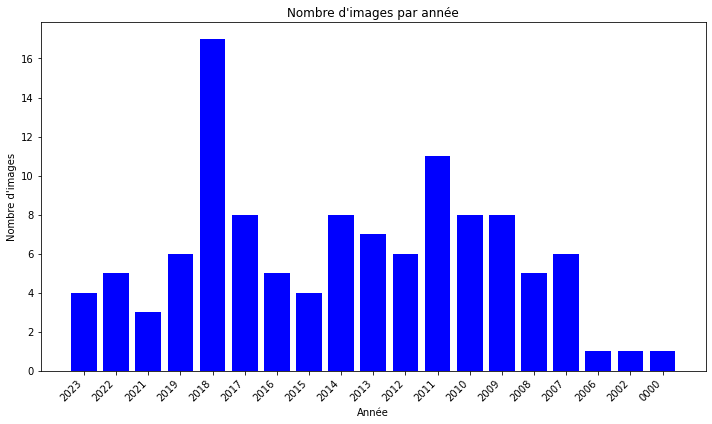

In [41]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# Charger les données JSON depuis un fichier
with open('./images_data_view.json', 'r') as file:
    data = json.load(file)

# Créer un dictionnaire pour stocker le nombre d'images par année
nombre_images_par_annee = defaultdict(int)

# Parcourir chaque objet d'image dans les données
for obj in data:
    # Extraire l'année à partir du champ "date_creation" si disponible
    date_creation = obj.get('date_creation')
    if date_creation:
        annee = date_creation.split(':')[0]
        nombre_images_par_annee[annee] += 1

# Trier les années par ordre décroissant
annees = sorted(nombre_images_par_annee.keys(), reverse=True)
nombre_images = [nombre_images_par_annee[annee] for annee in annees]

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.bar(annees, nombre_images, color='blue')
plt.xlabel('Année')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par année')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour éviter le chevauchement
plt.tight_layout()  # Ajuster la disposition pour éviter le recouvrement des étiquettes
plt.show()


### Nombre d'images pour chaque couleur

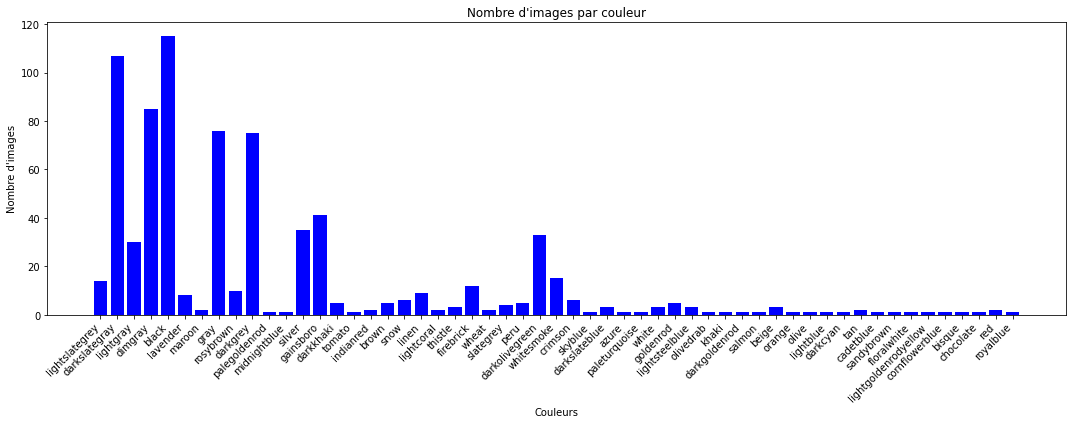

In [45]:
# Charger les données JSON depuis un fichier
with open('./images_data_view.json', 'r') as file:
    data = json.load(file)

# Créer un dictionnaire pour stocker le nombre d'images par couleur
nombre_images_par_couleur = defaultdict(int)

# Parcourir chaque objet d'image dans les données
for obj in data:
    # Extraire les couleurs à partir du champ "colors" si disponible
    couleurs = obj.get('colors')
    if couleurs:
        for couleur_liste in couleurs:
            for couleur in couleur_liste:
                nombre_images_par_couleur[couleur] += 1

# Extraire les couleurs et le nombre d'images pour créer le graphique
couleurs = list(nombre_images_par_couleur.keys())
nombre_images = list(nombre_images_par_couleur.values())

# Créer le graphique
plt.figure(figsize=(15, 6))
plt.bar(couleurs, nombre_images, color='blue')
plt.xlabel('Couleurs')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par couleur')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour éviter le chevauchement
plt.tight_layout()  # Ajuster la disposition pour éviter le recouvrement des étiquettes
plt.show()


### Nombre d'images pour chaque modèle d'appareil photo

C:\Users\grego\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\grego\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0, flags=flags)


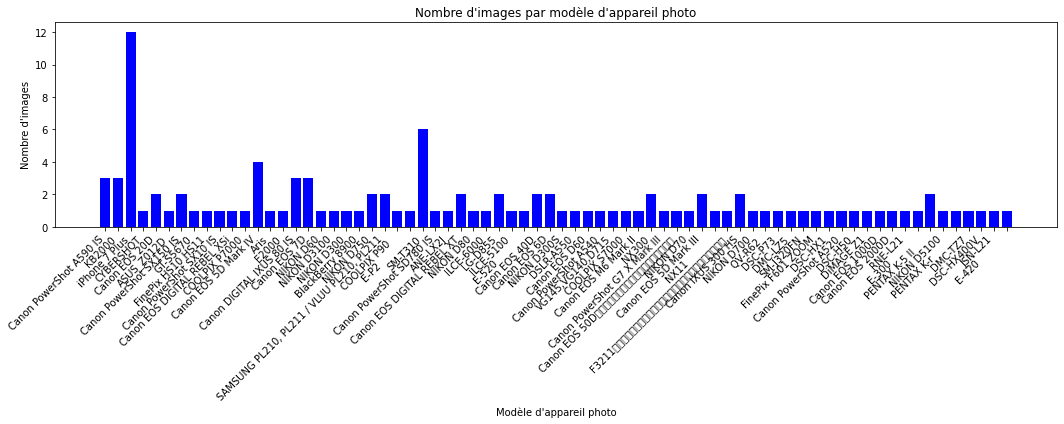

In [46]:
# Charger les données JSON depuis un fichier
with open('./images_data_view.json', 'r') as file:
    data = json.load(file)

# Créer un dictionnaire pour stocker le nombre d'images par modèle d'appareil photo
nombre_images_par_modele_appareil = defaultdict(int)

# Parcourir chaque objet d'image dans les données
for obj in data:
    # Extraire le modèle d'appareil photo à partir du champ "modele_appareil" si disponible
    modele_appareil = obj.get('modele_appareil')
    if modele_appareil:
        nombre_images_par_modele_appareil[modele_appareil] += 1

# Extraire les modèles d'appareil photo et le nombre d'images pour créer le graphique
modeles_appareil = list(nombre_images_par_modele_appareil.keys())
nombre_images = list(nombre_images_par_modele_appareil.values())

# Créer le graphique
plt.figure(figsize=(15, 6))
plt.bar(modeles_appareil, nombre_images, color='blue')
plt.xlabel('Modèle d\'appareil photo')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par modèle d\'appareil photo')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour éviter le chevauchement
plt.tight_layout()  # Ajuster la disposition pour éviter le recouvrement des étiquettes
plt.show()


### Nombre d'images par type d'orientation 

#### L'intégralité de nos images sont au format "Paysage"

### Nombre d'images par taille

#### Largeur

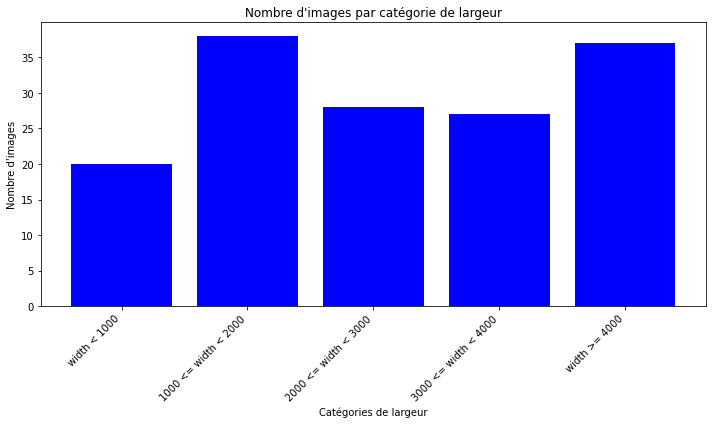

In [48]:
# Charger les données JSON depuis un fichier
with open('./images_data_view.json', 'r') as file:
    data = json.load(file)

# Définir les catégories de largeur
categories_largeur = {
    'width < 1000': 0,
    '1000 <= width < 2000': 0,
    '2000 <= width < 3000': 0,
    '3000 <= width < 4000': 0,
    'width >= 4000': 0
}

# Parcourir chaque objet d'image dans les données
for obj in data:
    # Extraire la largeur à partir du champ "taille" si disponible
    taille = obj.get('taille')
    if taille:
        largeur = taille[0]  # La largeur est le premier élément de la liste
        # Assigner la largeur à la catégorie correspondante
        if largeur < 1000:
            categories_largeur['width < 1000'] += 1
        elif 1000 <= largeur < 2000:
            categories_largeur['1000 <= width < 2000'] += 1
        elif 2000 <= largeur < 3000:
            categories_largeur['2000 <= width < 3000'] += 1
        elif 3000 <= largeur < 4000:
            categories_largeur['3000 <= width < 4000'] += 1
        else:
            categories_largeur['width >= 4000'] += 1

# Extraire les catégories de largeur et le nombre d'images pour créer le graphique
categories = list(categories_largeur.keys())
nombre_images = list(categories_largeur.values())

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.bar(categories, nombre_images, color='blue')
plt.xlabel('Catégories de largeur')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par catégorie de largeur')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour éviter le chevauchement
plt.tight_layout()  # Ajuster la disposition pour éviter le recouvrement des étiquettes
plt.show()


#### Hauteur

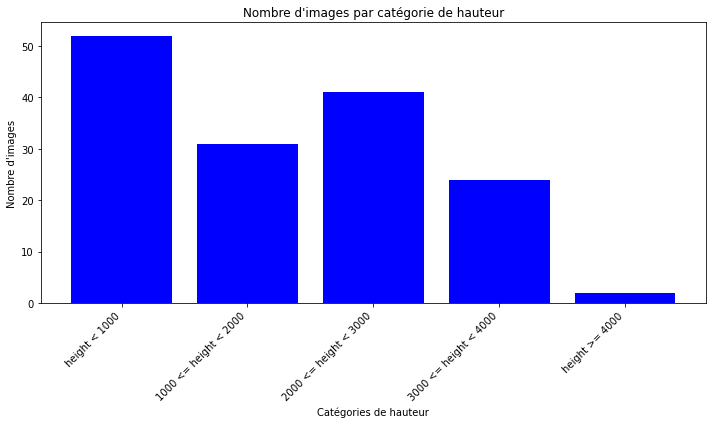

In [49]:
# Charger les données JSON depuis un fichier
with open('./images_data_view.json', 'r') as file:
    data = json.load(file)

# Définir les catégories de hauteur
categories_hauteur = {
    'height < 1000': 0,
    '1000 <= height < 2000': 0,
    '2000 <= height < 3000': 0,
    '3000 <= height < 4000': 0,
    'height >= 4000': 0
}

# Parcourir chaque objet d'image dans les données
for obj in data:
    # Extraire la hauteur à partir du champ "taille" si disponible
    taille = obj.get('taille')
    if taille:
        hauteur = taille[1]  # La hauteur est le deuxième élément de la liste
        # Assigner la hauteur à la catégorie correspondante
        if hauteur < 1000:
            categories_hauteur['height < 1000'] += 1
        elif 1000 <= hauteur < 2000:
            categories_hauteur['1000 <= height < 2000'] += 1
        elif 2000 <= hauteur < 3000:
            categories_hauteur['2000 <= height < 3000'] += 1
        elif 3000 <= hauteur < 4000:
            categories_hauteur['3000 <= height < 4000'] += 1
        else:
            categories_hauteur['height >= 4000'] += 1

# Extraire les catégories de hauteur et le nombre d'images pour créer le graphique
categories = list(categories_hauteur.keys())
nombre_images = list(categories_hauteur.values())

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.bar(categories, nombre_images, color='blue')
plt.xlabel('Catégories de hauteur')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par catégorie de hauteur')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour éviter le chevauchement
plt.tight_layout()  # Ajuster la disposition pour éviter le recouvrement des étiquettes
plt.show()


## 5 : Système de recommendation

In [169]:
"""
def get_recommended_images(username):
    # Initialiser un dictionnaire pour stocker les scores de similarité pour chaque image
    image_scores = defaultdict(float)

    # Obtenir les préférences de l'utilisateur sélectionné
    preferences = user_preferences.get(username, {})
    print("Préférences de l'utilisateur", username, ":", preferences)

    # Parcourir les données des utilisateurs
    for user in user_data:
        if user['username'] == username:
            print("Images sélectionnées par l'utilisateur", username, ":", user['selected_images'])
            # Parcourir les images sélectionnées par l'utilisateur
            for image_name in user['selected_images']:
                # Obtenir les données de l'image sélectionnée
                selected_image_data = next((image for image in all_images_data if image['nom'] == image_name), None)
                if selected_image_data:
                    print("Données de l'image", image_name, ":", selected_image_data)
                    # Comparer les préférences de l'utilisateur avec les données de l'image sélectionnée
                    # (tags, format, dimensions, couleurs, etc.) et attribuer un score de similarité

                    # Par exemple, pour les tags
                    for tag in selected_image_data.get('tags', []):
                        if tag in preferences.get('preferred_tag', []):
                            # Augmenter le score si le tag de l'image est dans les préférences de l'utilisateur
                            image_scores[selected_image_data['nom']] += 1

                    # Vous pouvez étendre cette logique pour les autres critères (format, dimensions, couleurs, etc.)

    # Filtrer les images déjà sélectionnées par l'utilisateur
    selected_images = set(image for user in user_data for image in user['selected_images'])

    # Trier les images par score de similarité
    sorted_images = sorted(image_scores.items(), key=lambda x: x[1], reverse=True)

    # Proposer les images similaires les plus pertinentes à l'utilisateur (par exemple, les 10 premières)
    recommended_images = list(islice((image for image, score in sorted_images if image not in selected_images), 10))

    print("Images recommandées pour l'utilisateur", username, ":", recommended_images)
    return recommended_images
"""

'\ndef get_recommended_images(username):\n    # Initialiser un dictionnaire pour stocker les scores de similarité pour chaque image\n    image_scores = defaultdict(float)\n\n    # Obtenir les préférences de l\'utilisateur sélectionné\n    preferences = user_preferences.get(username, {})\n    print("Préférences de l\'utilisateur", username, ":", preferences)\n\n    # Parcourir les données des utilisateurs\n    for user in user_data:\n        if user[\'username\'] == username:\n            print("Images sélectionnées par l\'utilisateur", username, ":", user[\'selected_images\'])\n            # Parcourir les images sélectionnées par l\'utilisateur\n            for image_name in user[\'selected_images\']:\n                # Obtenir les données de l\'image sélectionnée\n                selected_image_data = next((image for image in all_images_data if image[\'nom\'] == image_name), None)\n                if selected_image_data:\n                    print("Données de l\'image", image_name, ":

### Choisi un nom d'image aléatoire dans le json

In [182]:
def choisir_image_aleatoire():
    with open("images_data.json", 'r') as f:
        data = json.load(f)
    
    image_keys = list(data.keys())
    image_key = random.choice(image_keys)
    
    return image_key

### Récupère les tags d'une image

In [184]:
def getDataImage(image_name):
    with open("images_data.json", 'r') as f:
        image_data = json.load(f)
        
    image_data = image_data.get(image_name)
    
    if image_data:
        couleur_name = image_data.get("colors", [])
        if len(couleur_name[0]) >= 1:
            color1 = couleur_name[0][0]
        if len(couleur_name[0]) >= 2:
            color2 = couleur_name[0][1]
        orientation = image_data.get("orientation", "")
        tag = image_data.get("tags")
        return [color1,color2,tag[0],orientation]
    else:
        return []
    

### Récupère les données d'image sélectionnées d'un user

In [223]:
def get_image_data(username):
    with open('user_data.json', 'r') as f:
        user_data = json.load(f)

    with open('images_data.json', 'r') as f:
        image_data_json = json.load(f)

    for user in user_data:
        if user['username'] == username:
            fav_images = user['selected_images']
            unfav_images = user['unselected_images']

    data = []
    result = []

    # Récupérer les données pour chaque image dans file_names
    for image_name in fav_images:
        data.append(getDataImage(image_name))
        result.append("Favorite")
            
    # Récupérer les données pour chaque image dans file_names
    for image_name in unfav_images:
        data.append(getDataImage(image_name))
        result.append("NotFavorite")

    return data,result

data,result = get_image_data("old_user")

if data:
    for item in data:
        print(item)
    for item in result:
        print(item)
else:
    print("Utilisateur introuvable.")

['darkgrey', 'darkslategray', 'collection', 'paysage']
['darkslategray', 'whitesmoke', 'collection', 'paysage']
['darkslategray', 'white', 'collection', 'paysage']
['darkslategray', 'silver', 'collection', 'paysage']
['black', 'dimgray', 'collection', 'paysage']
['whitesmoke', 'dimgray', 'collection', 'paysage']
['gray', 'white', 'sport', 'paysage']
['dimgray', 'lavender', 'sport', 'paysage']
['darkslategray', 'darkgrey', 'city', 'paysage']
['black', 'lightgray', 'city', 'paysage']
['darkslategray', 'darkkhaki', 'collection', 'paysage']
['black', 'silver', 'collection', 'paysage']
['darkslategray', 'silver', 'collection', 'paysage']
['darkgrey', 'black', 'collection', 'paysage']
['dimgray', 'darkkhaki', 'collection', 'paysage']
['black', 'darkgrey', 'collection', 'paysage']
['darkgrey', 'black', 'collection', 'paysage']
['darkslategray', 'black', 'collection', 'paysage']
['dimgray', 'white', 'collection', 'paysage']
['lightgray', 'darkslategray', 'collection', 'paysage']
['darkgrey', '

### Prend une image aléatoire et la recommende ou non a l'utilisateur

In [226]:
# Encode categorical features and labels
label_encoders = [LabelEncoder() for _ in range(len(data[0]))]
encoded_data = []
for i, column in enumerate(zip(*data)):
    encoded_data.append(label_encoders[i].fit_transform(column))

X = list(zip(*encoded_data))  # Features
y = result  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression classifier
classifier = svm.SVC()
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

for _ in range(20):
    try:
        randomImageName = choisir_image_aleatoire()
        sample_item = getDataImage(randomImageName)
        # Sample prediction
        # sample_item = ['thistle', 'darkolivegreen', 'sport', 'paysage']  # Sample item attributes
        encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
        prediction = classifier.predict([encoded_item])[0]
        if(prediction == "Favorite"):
            print("Recomendation pour ",randomImageName,"avec comme caractéristique: ", sample_item)
            print(f"Prediction for the sample item: {prediction}")
    except ValueError as e:
        print(f"Erreur : {e}")

Accuracy: 0.5454545454545454
Recomendation pour  Image_106 avec comme caractéristique:  ['dimgray', 'gainsboro', 'city', 'paysage']
Recomendation pour  Image_93 avec comme caractéristique:  ['black', 'snow', 'collection', 'paysage']
Erreur : y contains previously unseen labels: 'snow'
Recomendation pour  Image_26 avec comme caractéristique:  ['black', 'gainsboro', 'city', 'paysage']
Recomendation pour  Image_116 avec comme caractéristique:  ['darkgrey', 'dimgray', 'city', 'paysage']
Recomendation pour  Image_104 avec comme caractéristique:  ['dimgray', 'darkkhaki', 'collection', 'paysage']
Recomendation pour  Image_128 avec comme caractéristique:  ['gray', 'black', 'city', 'paysage']
Recomendation pour  Image_25 avec comme caractéristique:  ['darkslategray', 'gray', 'city', 'paysage']
Recomendation pour  Image_107 avec comme caractéristique:  ['brown', 'darkgrey', 'city', 'paysage']
Prediction for the sample item: Favorite
Recomendation pour  Image_144 avec comme caractéristique:  ['da